In [2]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sn
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model


In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

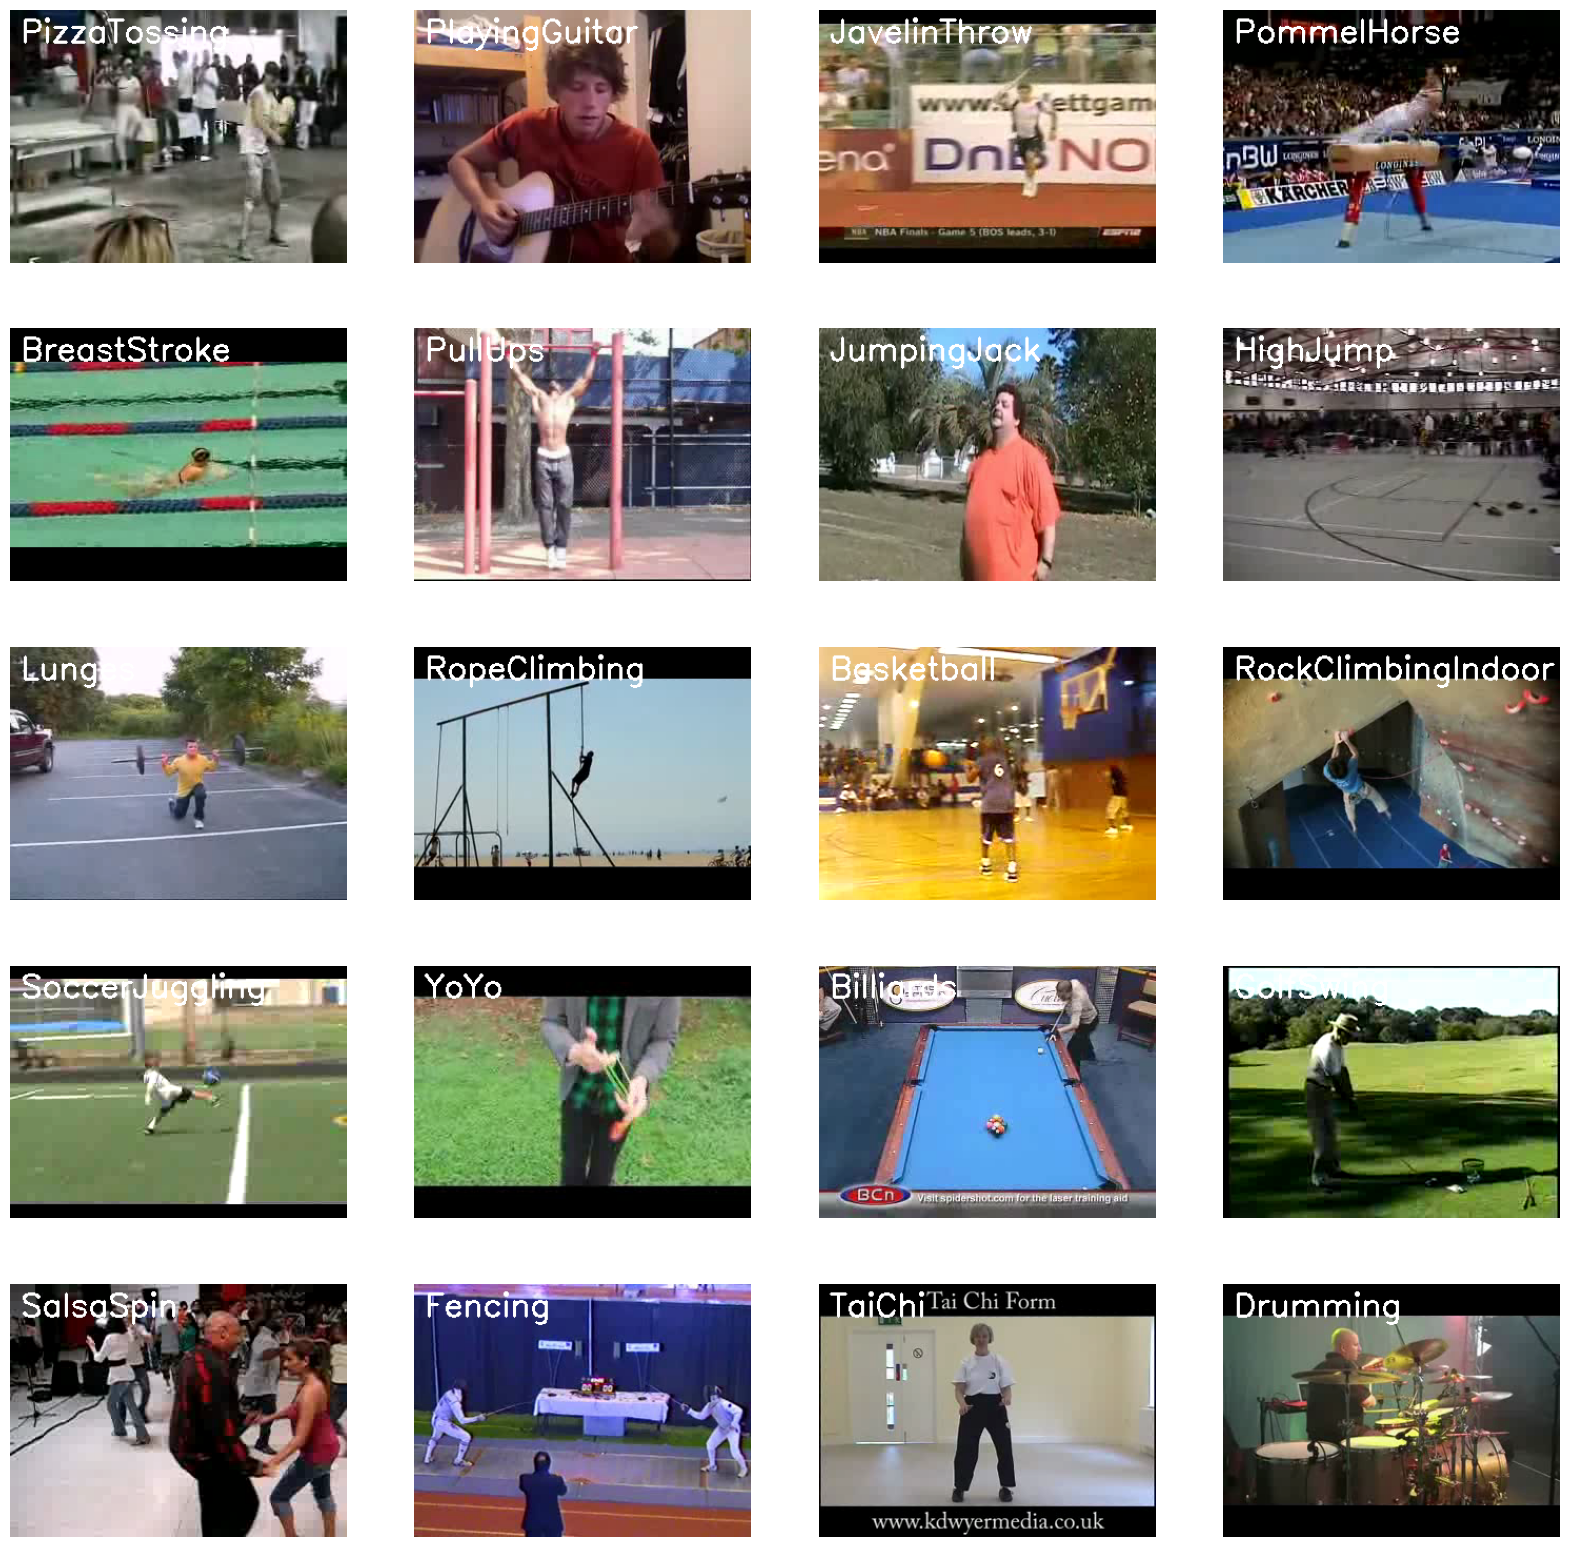

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing"]

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [10]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: Basketball
Extracting Data of Class: Rowing


In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [51]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

np.save('features_train.npy', features_train)
np.save('features_test.npy', features_test)
np.save('labels_train.npy', labels_train)
np.save('labels_test.npy', labels_test)

In [5]:

features_train = np.load('features_train.npy')
features_test = np.load('features_test.npy')
labels_train = np.load('labels_train.npy')
labels_test = np.load('labels_test.npy')

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))



    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

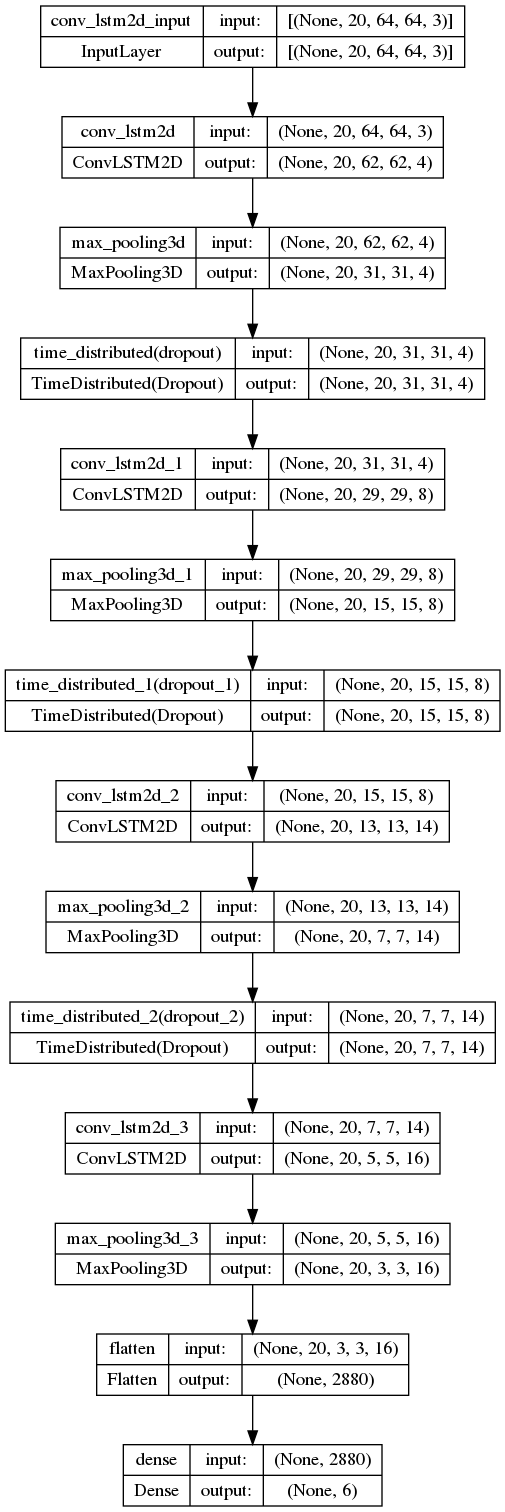

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs =70 , batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
114/114 [==============================] - 234s 2s/step - loss: 1.7875 - accuracy: 0.2171 - val_loss: 1.7853 - val_accuracy: 0.1754
Epoch 2/70
114/114 [==============================] - 219s 2s/step - loss: 1.7018 - accuracy: 0.2917 - val_loss: 1.5943 - val_accuracy: 0.3421
Epoch 3/70
114/114 [==============================] - 220s 2s/step - loss: 1.5040 - accuracy: 0.3991 - val_loss: 1.4735 - val_accuracy: 0.4123
Epoch 4/70
114/114 [==============================] - 219s 2s/step - loss: 1.2385 - accuracy: 0.5197 - val_loss: 1.1545 - val_accuracy: 0.5965
Epoch 5/70
114/114 [==============================] - 221s 2s/step - loss: 0.9397 - accuracy: 0.6623 - val_loss: 0.9853 - val_accuracy: 0.6842
Epoch 6/70
114/114 [==============================] - 220s 2s/step - loss: 0.7180 - accuracy: 0.7390 - val_loss: 1.6928 - val_accuracy: 0.4561
Epoch 7/70
114/114 [==============================] - 222s 2s/step - loss: 0.6765 - accuracy: 0.7632 - val_loss: 0.9767 - val_accuracy: 0.6404

**<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 14s 2s/step - loss: 0.7801 - accuracy: 0.7225


In [111]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

NameError: name 'convlstm_model' is not defined

In [13]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

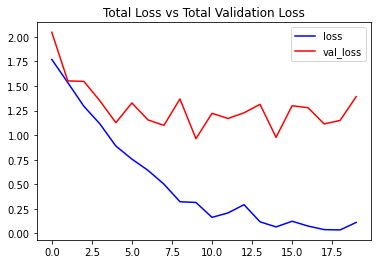

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

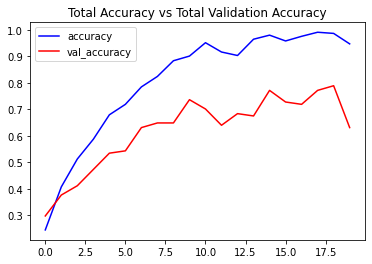

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**<font style="color:rgb(134,19,348)">Confusion Matrix Visualize</font>**

In [ ]:
# Evaluate the confusion_marix.
convlstm_model.predict(np.expand_dims(features_test[0], axis=0)).round(2)

1/1 [==============================] - 0s 103ms/step


array([[0.02, 0.  , 0.96, 0.  , 0.01, 0.01]], dtype=float32)

In [ ]:
y_test=np.argmax(labels_test,axis=-1)

In [ ]:
labels_test[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
# predict the features_test data
y_pred = np.argmax(convlstm_model.predict(features_test),axis=1)
y_pred

6/6 [==============================] - 17s 3s/step


array([2, 3, 1, 3, 0, 0, 0, 2, 4, 1, 2, 4, 2, 2, 3, 5, 4, 2, 0, 0, 3, 0,
       4, 2, 2, 3, 2, 3, 4, 3, 5, 4, 2, 2, 5, 4, 0, 1, 4, 0, 4, 5, 3, 0,
       3, 3, 2, 0, 5, 1, 1, 0, 0, 5, 3, 4, 5, 3, 2, 0, 0, 0, 0, 1, 2, 4,
       4, 1, 5, 2, 4, 2, 1, 1, 3, 4, 0, 3, 0, 0, 4, 4, 4, 5, 2, 0, 2, 0,
       5, 2, 1, 1, 0, 0, 4, 3, 2, 3, 0, 4, 5, 2, 1, 5, 2, 0, 5, 3, 5, 0,
       0, 0, 4, 0, 3, 4, 1, 4, 3, 2, 1, 1, 4, 3, 2, 4, 5, 0, 4, 2, 3, 2,
       1, 5, 0, 4, 0, 2, 4, 4, 4, 0, 5, 0, 0, 4, 1, 1, 0, 0, 2, 5, 3, 0,
       5, 4, 5, 5, 3, 2, 0, 4, 5, 1, 3, 1, 3, 5, 1, 3, 3, 2, 5, 2, 0, 5,
       1, 4, 4, 5, 0, 3, 4, 2, 5, 5, 4, 3, 2, 2, 2])

In [ ]:
# Display the Acuuracy
print('Accuracy score :', accuracy_score(y_test, y_pred))

Accuracy score : 0.8795811518324608


In [ ]:
# Plot the confusion_matrix of convlstm.
plt.figure(figsize=(16,9))
y_pred_labels = [np.argmax(label) for label in y_pred ]
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix


<Figure size 1152x648 with 0 Axes>

Text(0.5, 51.0, 'Predicted Labels')

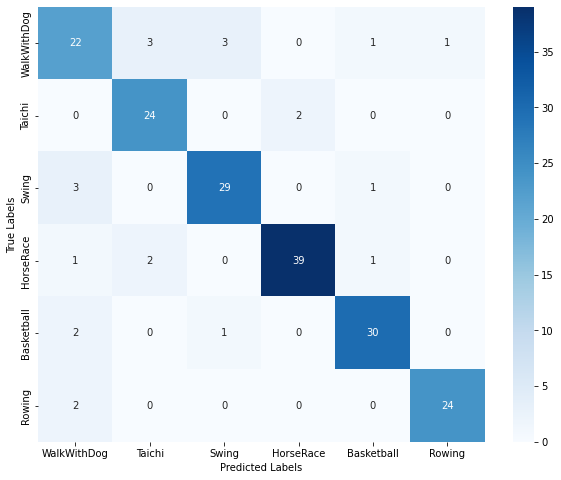

In [ ]:
# Visualize the confusion_matrix of convlstm.
plt.figure(figsize=(10,8))
x_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
y_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
sn.heatmap(data = cm, annot = True, cmap = 'Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [ ]:
label_names = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

 WalkWithDog       0.73      0.73      0.73        30
      Taichi       0.83      0.92      0.87        26
       Swing       0.88      0.88      0.88        33
   HorseRace       0.95      0.91      0.93        43
  Basketball       0.91      0.91      0.91        33
      Rowing       0.96      0.92      0.94        26

    accuracy                           0.88       191
   macro avg       0.88      0.88      0.88       191
weighted avg       0.88      0.88      0.88       191



 MODEL

In [14]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [15]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

/Users/justin/anaconda3/envs/human/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,126 (285.65 KB)

 Trainable params: 73,126 (285.65 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [17]:
# Plot the structure of the contructed LRCN model.
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [18]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.1259 - loss: 1.8223 - val_accuracy: 0.2193 - val_loss: 1.7629
Epoch 2/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.1976 - loss: 1.7852 - val_accuracy: 0.2895 - val_loss: 1.6610
Epoch 3/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.3038 - loss: 1.6617 - val_accuracy: 0.3070 - val_loss: 1.5290
Epoch 4/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.3297 - loss: 1.5794 - val_accuracy: 0.4298 - val_loss: 1.4446
Epoch 5/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.4083 - loss: 1.4613 - val_accuracy: 0.4386 - val_loss: 1.3368
Epoch 6/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.4592 - loss: 1.2858 - val_accuracy: 0.5263 - val_loss: 1.2520
Epoch 7/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.4903 - loss: 1.3582 - val_accuracy: 0.6053 - val_loss: 1.1634
Epoch 8/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.6302 - loss: 0.9820 - 

In [31]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8807 - loss: 0.3745


In [118]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.keras'

# Save the Model.
save_model(LRCN_model,model_file_name)

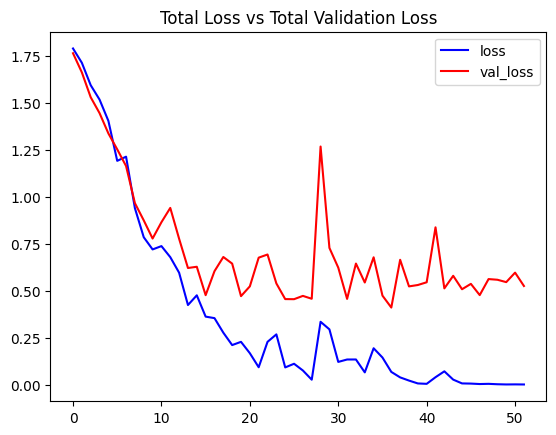

In [33]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

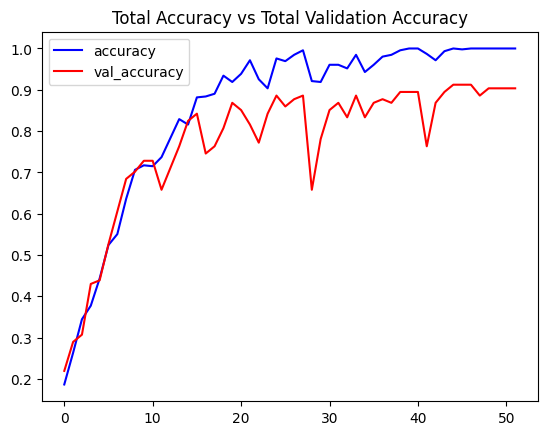

In [22]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Confusion Matrix

In [67]:
y_test=np.argmax(labels_test,axis=-1)

In [68]:
# predict the features_test data
y_pred = np.argmax(LRCN_model.predict(features_test),axis=1)
y_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


array([4, 3, 1, 3, 4, 5, 0, 0, 4, 2, 4, 4, 0, 2, 3, 5, 4, 3, 0, 2, 3, 3,
       4, 2, 2, 3, 2, 3, 4, 3, 5, 0, 2, 2, 5, 4, 1, 1, 4, 5, 1, 3, 3, 0,
       3, 3, 2, 0, 5, 0, 3, 2, 2, 5, 3, 4, 5, 3, 2, 0, 2, 0, 1, 1, 2, 4,
       3, 1, 3, 2, 4, 2, 1, 1, 0, 4, 3, 3, 5, 1, 0, 4, 5, 5, 0, 2, 4, 0,
       4, 2, 1, 1, 0, 0, 2, 3, 5, 3, 3, 4, 3, 4, 1, 5, 2, 2, 5, 3, 3, 0,
       0, 2, 4, 2, 2, 4, 1, 2, 3, 0, 1, 1, 1, 3, 2, 4, 3, 3, 4, 2, 3, 2,
       1, 5, 3, 4, 1, 5, 5, 0, 4, 1, 0, 1, 2, 4, 1, 0, 3, 0, 2, 5, 3, 3,
       5, 1, 5, 3, 3, 1, 3, 4, 5, 1, 3, 5, 3, 5, 1, 3, 3, 4, 5, 2, 0, 0,
       1, 2, 4, 0, 3, 3, 3, 3, 5, 2, 4, 3, 2, 0, 5])

In [69]:
# Display the Acuuracy
print('Accuracy score :', accuracy_score(y_test, y_pred))

Accuracy score : 0.8638743455497382


In [70]:
# Plot the confusion_matrix of convlstm.
plt.figure(figsize=(16,9))
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix


<Figure size 1600x900 with 0 Axes>

Text(0.5, 58.7222222222222, 'Predicted Labels')

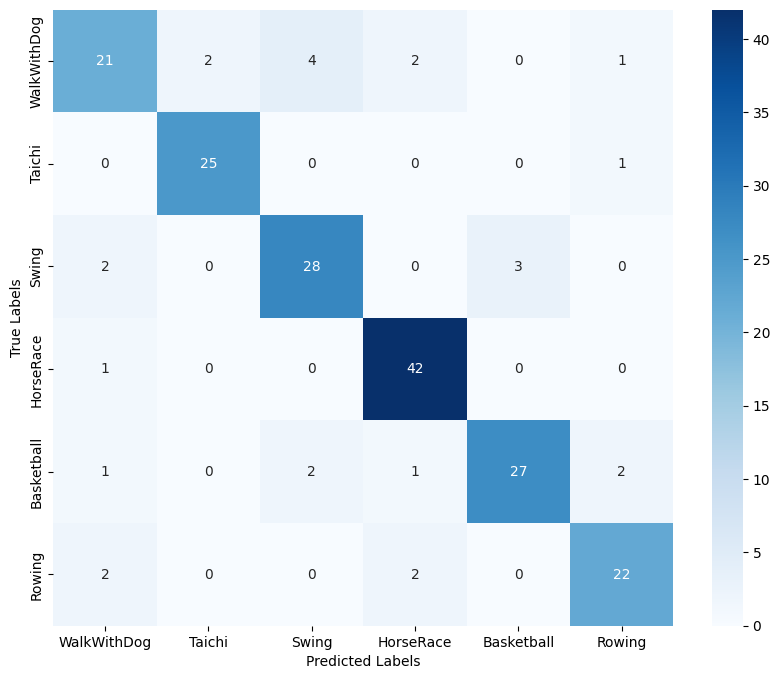

In [71]:
# Visualize the confusion_matrix of convlstm.
plt.figure(figsize=(10,8))
x_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
y_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
sn.heatmap(data = cm, annot = True, cmap = 'Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [72]:
label_names = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

 WalkWithDog       0.78      0.70      0.74        30
      Taichi       0.93      0.96      0.94        26
       Swing       0.82      0.85      0.84        33
   HorseRace       0.89      0.98      0.93        43
  Basketball       0.90      0.82      0.86        33
      Rowing       0.85      0.85      0.85        26

    accuracy                           0.86       191
   macro avg       0.86      0.86      0.86       191
weighted avg       0.86      0.86      0.86       191



## Approximation

In [3]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm1 import *

import statistics

lrcn = load_model('model/LRCN_model___Date_Time_2024_03_06__17_12_56___Loss_0.4536501467227936___Accuracy_0.8638743162155151.keras')

y_test = np.argmax(labels_test, axis=-1)
y_pred = np.argmax(lrcn(features_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)

accuracy

/Users/justin/anaconda3/envs/human/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


NameError: name 'labels_test' is not defined

In [26]:
def approximate_weight(mse_threshold, layer):
    Nsteps = 500
    NZ_W = 14
    Tc_W = 4
    Tr_W = 1

    NZ_H = 6
    Tc_H = 4
    Tr_H = 1
    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    
    kernel, recurrent_kernel, bias = layer.get_weights()

    # Input gate weights and biases
    W_i = Weight()
    W_i.init_weight(kernel[:, :layer.units])
    
    W_i_approximated = W_i.iterative_approximation(mse_threshold,NZ_W,Nsteps,Tc_W,Tr_W)

    H_i = Weight()
    H_i.init_weight(recurrent_kernel[:, :layer.units])
    H_i_approximated = H_i.iterative_approximation(mse_threshold,NZ_H,Nsteps,Tc_H,Tr_H)

    W_f = Weight()
    W_f.init_weight(kernel[:, layer.units:layer.units*2])
    W_f_approximated = W_f.iterative_approximation(mse_threshold,NZ_W,Nsteps,Tc_W,Tr_W)

    H_f = Weight()
    H_f.init_weight(recurrent_kernel[:, layer.units:layer.units*2])
    H_f_approximated = H_f.iterative_approximation(mse_threshold,NZ_H,Nsteps,Tc_H,Tr_H)

    W_o = Weight()
    W_o.init_weight(kernel[:, layer.units*2:layer.units*3])
    W_o_approximated = W_o.iterative_approximation(mse_threshold,NZ_W,Nsteps,Tc_W,Tr_W)

    H_o = Weight()
    H_o.init_weight(recurrent_kernel[:, layer.units*2:layer.units*3])
    H_o_approximated = H_o.iterative_approximation(mse_threshold,NZ_H,Nsteps,Tc_H,Tr_H)

    W_c = Weight()
    W_c.init_weight(kernel[:, layer.units*3:])
    W_c_approximated = W_c.iterative_approximation(mse_threshold,NZ_W,Nsteps,Tc_W,Tr_W)

    H_c = Weight()
    H_c.init_weight(recurrent_kernel[:, layer.units*3:])
    H_c_approximated = H_c.iterative_approximation(mse_threshold,NZ_H,Nsteps,Tc_H,Tr_H)

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    W_compression_ratio = statistics.mean([W_i.compression_ratio(), W_f.compression_ratio(), W_o.compression_ratio(), W_c.compression_ratio()])
    H_compression_ratio = statistics.mean([H_i.compression_ratio(), H_f.compression_ratio(), H_o.compression_ratio(), H_c.compression_ratio()])

    

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [27]:
def approximate_weight2(Nsteps, NZ, Tr, Tc, mse_threshold, layer):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    kernel, recurrent_kernel, bias = layer.get_weights()

    input_len = kernel[:, :layer.units].shape[0]

    # Input gate weights and biases
    i = Weight()
    i.init_weight(np.vstack((kernel[:, :layer.units],recurrent_kernel[:, :layer.units])))
    i_approximated = i.iterative_approximation(mse_threshold, NZ, Nsteps, Tc, Tr)

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f = Weight()
    f.init_weight(np.vstack((kernel[:, layer.units:layer.units*2],recurrent_kernel[:, layer.units:layer.units*2])))
    f_approximated = f.iterative_approximation(mse_threshold, NZ, Nsteps, Tc, Tr)

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o = Weight()
    o.init_weight(np.vstack((kernel[:, layer.units*2:layer.units*3],recurrent_kernel[:, layer.units*2:layer.units*3])))
    o_approximated = o.iterative_approximation(mse_threshold, NZ, Nsteps, Tc, Tr)

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c = Weight()
    c.init_weight(np.vstack((kernel[:, layer.units*3:],recurrent_kernel[:, layer.units*3:])))
    c_approximated = c.iterative_approximation(mse_threshold, NZ, Nsteps, Tc, Tr)

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])
    H_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [28]:
def approximate_weight2_step(Nsteps, NZ, Tr, Tc, layer):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    kernel, recurrent_kernel, bias = layer.get_weights()

    input_len = kernel[:, :layer.units].shape[0]

    # Input gate weights and biases
    i = Weight()
    i.init_weight(np.vstack((kernel[:, :layer.units],recurrent_kernel[:, :layer.units])))
    i_approximated = i.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f = Weight()
    f.init_weight(np.vstack((kernel[:, layer.units:layer.units*2],recurrent_kernel[:, layer.units:layer.units*2])))
    f_approximated = f.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o = Weight()
    o.init_weight(np.vstack((kernel[:, layer.units*2:layer.units*3],recurrent_kernel[:, layer.units*2:layer.units*3])))
    o_approximated = o.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c = Weight()
    c.init_weight(np.vstack((kernel[:, layer.units*3:],recurrent_kernel[:, layer.units*3:])))
    c_approximated = c.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])
    H_compression_ratio= statistics.mean([i.compression_ratio(), f.compression_ratio(), o.compression_ratio(), c.compression_ratio()])

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [29]:
def approximate_weight4_1(Nsteps, NZ, Tr, Tc, mse_threshold, layer):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    
    kernel, recurrent_kernel, bias = layer.get_weights()

    input_len = kernel[:, :layer.units].shape[0]

    input_hidden_len = input_len + recurrent_kernel[:, :layer.units].shape[0]
    
    # Input gate weights and biases
    W = Weight()
    W.init_weight(np.vstack([kernel[:, :layer.units],recurrent_kernel[:, :layer.units],kernel[:, layer.units:layer.units*2],recurrent_kernel[:, layer.units:layer.units*2],kernel[:, layer.units*2:layer.units*3],recurrent_kernel[:, layer.units*2:layer.units*3],kernel[:, layer.units*3:],recurrent_kernel[:, layer.units*3:]]))
    W_approximated = W.iterative_approximation(mse_threshold, NZ, Nsteps, Tc, Tr)

    i_approximated = W_approximated[:,:input_hidden_len]

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f_approximated = W_approximated[:,input_hidden_len:input_hidden_len*2]

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o_approximated = W_approximated[:,input_hidden_len*2:input_hidden_len*3]

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c_approximated = W_approximated[:,input_hidden_len*3:]

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= W.compression_ratio()
    H_compression_ratio= W.compression_ratio()

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [30]:
def approximate_weight4_2(Nsteps, NZ, Tr, Tc, mse_threshold, layer):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    
    kernel, recurrent_kernel, bias = layer.get_weights()

    input_len = kernel[:, :layer.units].shape[0]

    input_hidden_len = input_len + recurrent_kernel[:, :layer.units].shape[0]

    w = np.vstack([kernel[:, :layer.units],recurrent_kernel[:, :layer.units]])
    f = np.vstack([kernel[:, layer.units:layer.units*2],recurrent_kernel[:, layer.units:layer.units*2]])
    o = np.vstack([kernel[:, layer.units*2:layer.units*3],recurrent_kernel[:, layer.units*2:layer.units*3]])
    c = np.vstack([kernel[:, layer.units*3:],recurrent_kernel[:, layer.units*3:]])

    # Input gate weights and biases
    W = Weight()
    W.init_weight(np.hstack([w,f,o,c]))
    W_approximated = W.iterative_approximation(mse_threshold, NZ, Nsteps, Tc, Tr)

    i_approximated = W_approximated[:input_hidden_len,:]

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f_approximated = W_approximated[input_hidden_len:input_hidden_len*2,:]

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o_approximated = W_approximated[input_hidden_len*2:input_hidden_len*3,:]

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c_approximated = W_approximated[input_hidden_len*3:,:]

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= W.compression_ratio()
    H_compression_ratio= W.compression_ratio()

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [31]:
def approximate_weight4_2_step(Nsteps, NZ, Tr, Tc, layer):

    # For standard Keras LSTM layers, the ordering within these is [input_gate, forget_gate, cell_state, output_gate]
    
    kernel, recurrent_kernel, bias = layer.get_weights()

    input_len = kernel[:, :layer.units].shape[0]

    input_hidden_len = input_len + recurrent_kernel[:, :layer.units].shape[0]

    w = np.vstack([kernel[:, :layer.units],recurrent_kernel[:, :layer.units]])
    f = np.vstack([kernel[:, layer.units:layer.units*2],recurrent_kernel[:, layer.units:layer.units*2]])
    o = np.vstack([kernel[:, layer.units*2:layer.units*3],recurrent_kernel[:, layer.units*2:layer.units*3]])
    c = np.vstack([kernel[:, layer.units*3:],recurrent_kernel[:, layer.units*3:]])

    # Input gate weights and biases
    W = Weight()
    W.init_weight(np.hstack([w,f,o,c]))
    W_approximated = W.iterative_approximation_step(NZ, Nsteps, Tc, Tr)

    i_approximated = W_approximated[:input_hidden_len,:]

    W_i_approximated = i_approximated[:,:input_len]
    H_i_approximated = i_approximated[:,input_len:]

    f_approximated = W_approximated[input_hidden_len:input_hidden_len*2,:]

    W_f_approximated = f_approximated[:,:input_len]
    H_f_approximated = f_approximated[:,input_len:]


    o_approximated = W_approximated[input_hidden_len*2:input_hidden_len*3,:]

    W_o_approximated = o_approximated[:,:input_len]
    H_o_approximated = o_approximated[:,input_len:]

    c_approximated = W_approximated[input_hidden_len*3:,:]

    W_c_approximated = c_approximated[:,:input_len]
    H_c_approximated = c_approximated[:,input_len:]

    W_compression_ratio= W.compression_ratio()
    H_compression_ratio= W.compression_ratio()

    approximated_kernel = np.hstack((np.transpose(W_i_approximated), np.transpose(W_f_approximated), np.transpose(W_o_approximated), np.transpose(W_c_approximated)))
    approximated_recurrent_kernel = np.hstack((np.transpose(H_i_approximated), np.transpose(H_f_approximated), np.transpose(H_o_approximated), np.transpose(H_c_approximated)))

    return approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio

In [190]:
%%capture
original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list1 = np.linspace(0.000001, 0.012, 50)

testing_accuracies1 = []
W_compression_ratios1 = []
H_compression_ratios1 = []

for mse_threshold in mse_threshold_list1:
    # print("MSE threshold:", mse_threshold)

    # Reset to original weights before each approximation
    lrcn.layers[-2].set_weights(original_weights)
    
    # Perform weight approximation
    approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight(mse_threshold, lrcn.layers[-2])

    # Set the approximated weights
    approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
    lrcn.layers[-2].set_weights(approximated_weights)

    y_test=np.argmax(labels_test,axis=-1)
    y_pred = np.argmax(lrcn(features_test), axis=1)

    # Evaluate the model with approximated weights
    accuracy = accuracy_score(y_test, y_pred)

    # Collect metrics
    testing_accuracies1.append(accuracy)
    W_compression_ratios1.append(W_compression_ratio)
    H_compression_ratios1.append(H_compression_ratio)


lrcn.layers[-2].set_weights(original_weights)

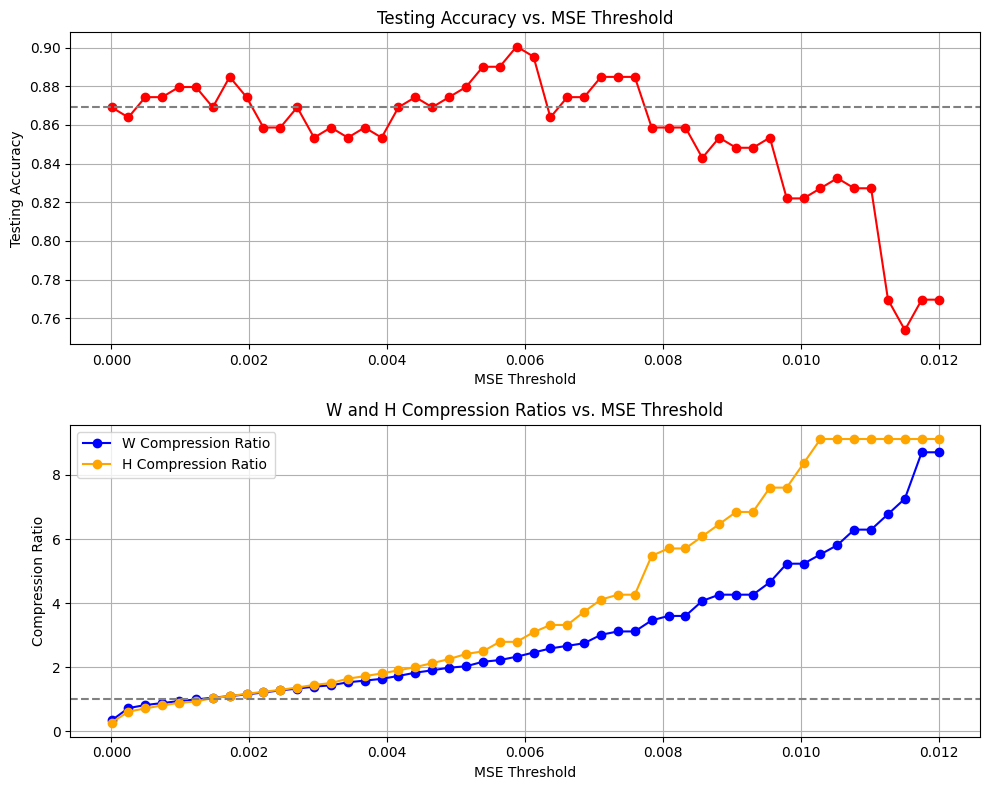

In [191]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Create two subplots vertically aligned

# Testing Accuracy vs. MSE Threshold
axs[0].plot(mse_threshold_list1, testing_accuracies1, marker='o', linestyle='-', color='r')
axs[0].set_title('Testing Accuracy vs. MSE Threshold')
axs[0].set_xlabel('MSE Threshold')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
# Add a horizontal dashed line at the height of testing_accuracies[0]
axs[0].axhline(y=testing_accuracies1[0], color='gray', linestyle='--')

# W and H Compression Ratios vs. MSE Threshold
axs[1].plot(mse_threshold_list1, W_compression_ratios1, marker='o', linestyle='-', color='b', label='W Compression Ratio')
axs[1].plot(mse_threshold_list1, H_compression_ratios1, marker='o', linestyle='-', color='orange', label='H Compression Ratio')
axs[1].set_title('W and H Compression Ratios vs. MSE Threshold')
axs[1].set_xlabel('MSE Threshold')
axs[1].set_ylabel('Compression Ratio')
axs[1].legend()
axs[1].grid(True)
axs[1].axhline(y=1, color='gray', linestyle='--')

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()  # Display the plots

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/2174113550.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


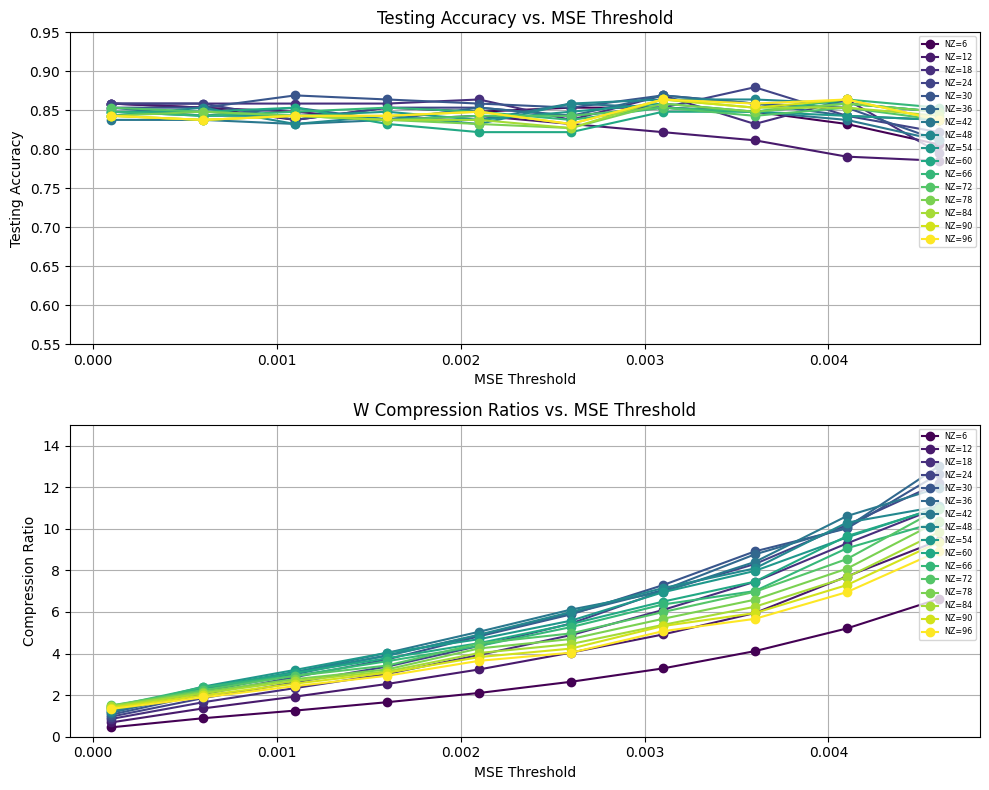

In [244]:
# %%capture
from matplotlib.cm import get_cmap

original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list2 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc = 1

NZ_list = list(range(6, 96 + 1, 6))

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for mse_threshold in mse_threshold_list2:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight2(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        y_test = np.argmax(labels_test, axis=-1)
        y_pred = np.argmax(lrcn(features_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(mse_threshold_list2, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(mse_threshold_list2, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. MSE Threshold')
axs[0].set_xlabel('MSE Threshold')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='upper right', fontsize='xx-small')
axs[0].set_ylim(0.55, 0.95)

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. MSE Threshold')
axs[1].set_xlabel('MSE Threshold')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')
axs[1].set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/2685291055.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mse_color_map = get_cmap('plasma')


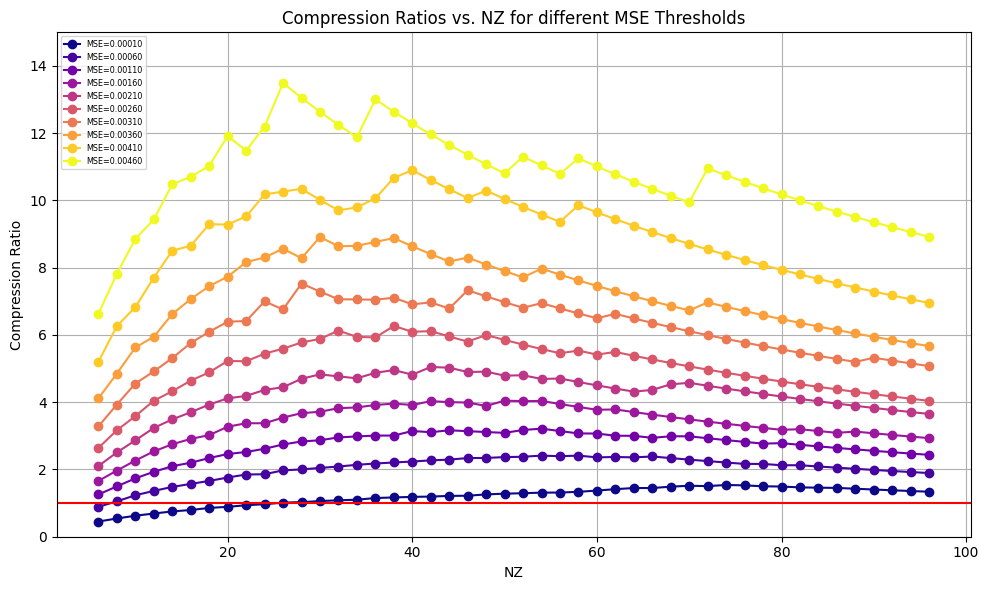

In [247]:
original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list2 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc = 1

NZ_list = list(range(6, 96 + 1, 2))

# Define color map for MSE thresholds
mse_color_map = get_cmap('plasma')
mse_colors = mse_color_map(np.linspace(0, 1, len(mse_threshold_list2)))

# Separate Plot for Compression Ratios vs. NZ for different MSE Thresholds
fig, ax = plt.subplots(figsize=(10, 6))  # Dedicated figure and axes for this plot

for mse_index, mse_threshold in enumerate(mse_threshold_list2):
    # Reset metrics for each MSE threshold
    W_compression_ratios_mse = []

    for NZ in NZ_list:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, _ = approximate_weight2(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Collect metrics for the current MSE threshold
        W_compression_ratios_mse.append(W_compression_ratio)

    # Plotting for the current MSE threshold with its corresponding color
    mse_color = mse_colors[mse_index]
    ax.plot(NZ_list, W_compression_ratios_mse, marker='o', linestyle='-', color=mse_color, label=f'MSE={mse_threshold:.5f}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Setting title, labels, and legend
ax.set_title('Compression Ratios vs. NZ for different MSE Thresholds')
ax.set_xlabel('NZ')
ax.set_ylabel('Compression Ratio')
ax.grid(True)
ax.legend(loc='upper left', fontsize='xx-small')
ax.axhline(y=1, color='red', linestyle='-')
ax.set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/492834866.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


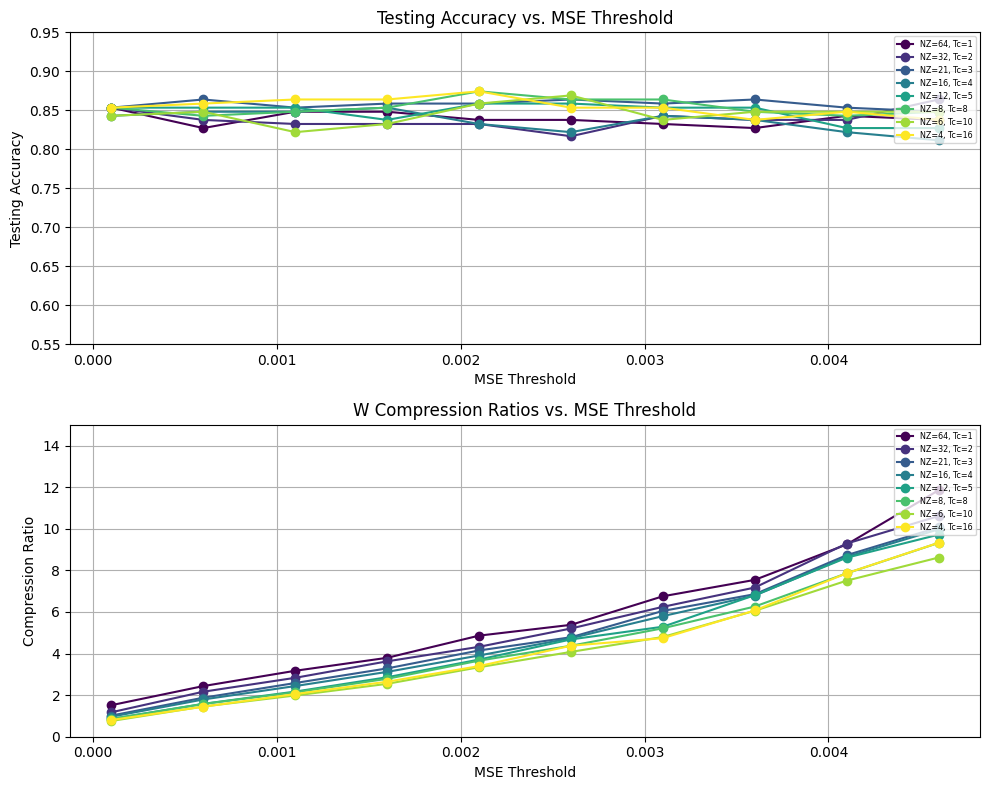

In [258]:
# %%capture
from matplotlib.cm import get_cmap

original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list2 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc_list = [1, 2, 3, 4, 5, 8, 10, 16]

NZ_list = [64, 32, 21, 16, 12, 8, 6, 4]

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []
    Tc = Tc_list[nz_index]
    for mse_threshold in mse_threshold_list2:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight2(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        y_test = np.argmax(labels_test, axis=-1)
        y_pred = np.argmax(lrcn(features_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(mse_threshold_list2, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}, Tc={Tc}')
    axs[1].plot(mse_threshold_list2, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}, Tc={Tc}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. MSE Threshold')
axs[0].set_xlabel('MSE Threshold')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='upper right', fontsize='xx-small')
axs[0].set_ylim(0.55, 0.95)

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. MSE Threshold')
axs[1].set_xlabel('MSE Threshold')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')
axs[1].set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/2218934129.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


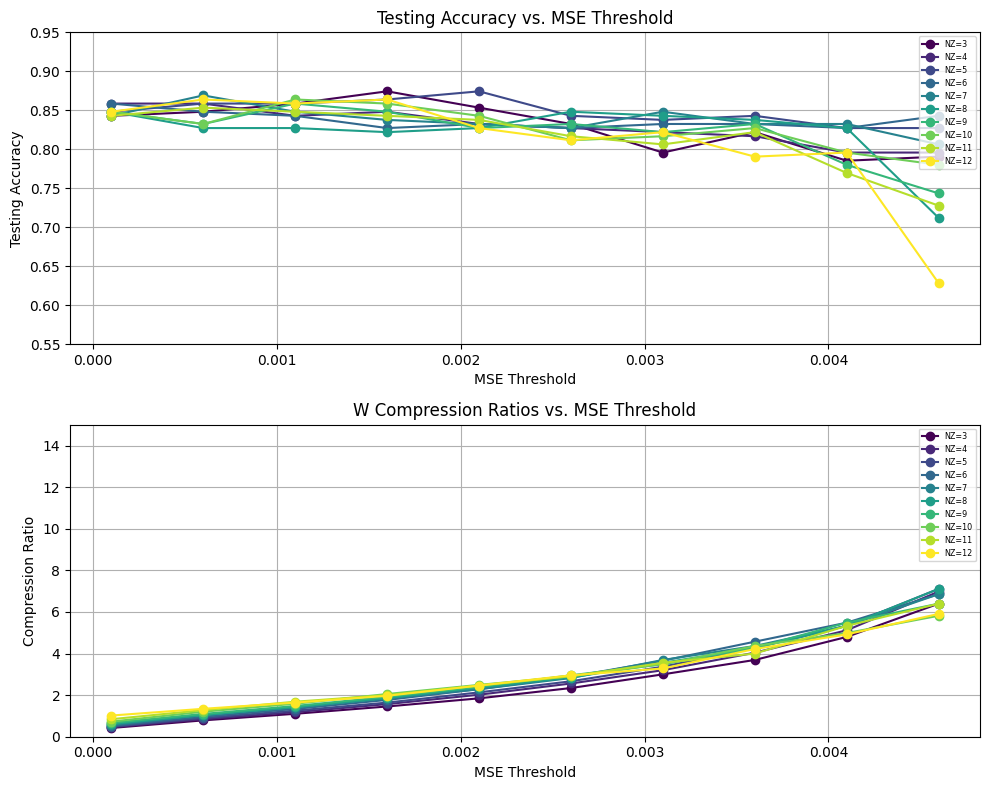

In [273]:
# %%capture

mse_threshold_list4_1 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc = 32

NZ_list = list(range(3, 12 + 1, 1))

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for mse_threshold in mse_threshold_list2:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight4_1(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        y_test = np.argmax(labels_test, axis=-1)
        y_pred = np.argmax(lrcn(features_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(mse_threshold_list4_1, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(mse_threshold_list4_1, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. MSE Threshold')
axs[0].set_xlabel('MSE Threshold')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='upper right', fontsize='xx-small')
axs[0].set_ylim(0.55, 0.95)

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. MSE Threshold')
axs[1].set_xlabel('MSE Threshold')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')
axs[1].set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/3844014910.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mse_color_map = get_cmap('plasma')


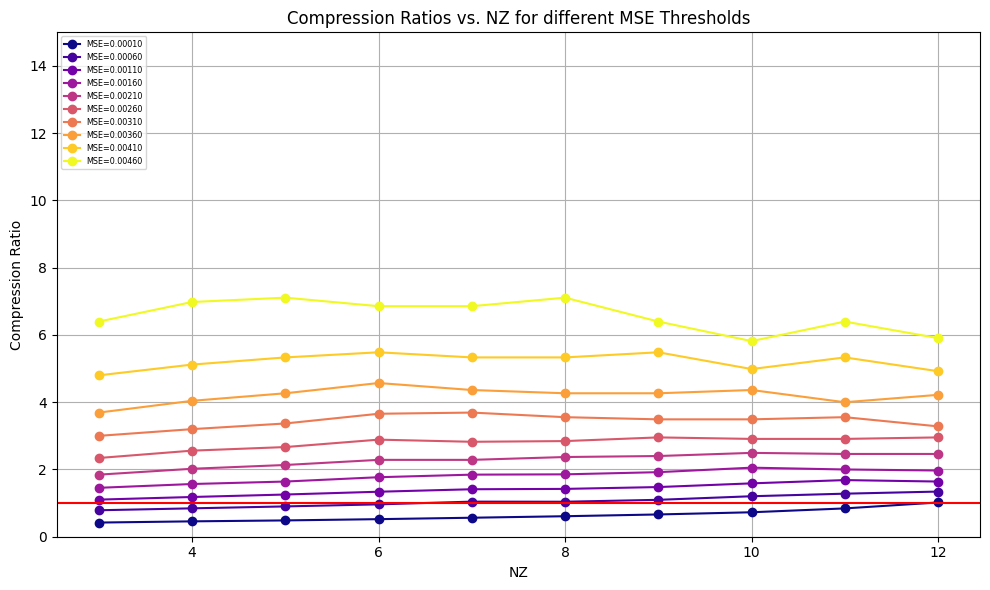

In [272]:
original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list4_1 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc = 32

NZ_list = list(range(3, 12 + 1, 1))

# Define color map for MSE thresholds
mse_color_map = get_cmap('plasma')
mse_colors = mse_color_map(np.linspace(0, 1, len(mse_threshold_list2)))

# Separate Plot for Compression Ratios vs. NZ for different MSE Thresholds
fig, ax = plt.subplots(figsize=(10, 6))  # Dedicated figure and axes for this plot

for mse_index, mse_threshold in enumerate(mse_threshold_list2):
    # Reset metrics for each MSE threshold
    W_compression_ratios_mse = []

    for NZ in NZ_list:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, _ = approximate_weight4_1(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Collect metrics for the current MSE threshold
        W_compression_ratios_mse.append(W_compression_ratio)

    # Plotting for the current MSE threshold with its corresponding color
    mse_color = mse_colors[mse_index]
    ax.plot(NZ_list, W_compression_ratios_mse, marker='o', linestyle='-', color=mse_color, label=f'MSE={mse_threshold:.5f}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Setting title, labels, and legend
ax.set_title('Compression Ratios vs. NZ for different MSE Thresholds')
ax.set_xlabel('NZ')
ax.set_ylabel('Compression Ratio')
ax.grid(True)
ax.legend(loc='upper left', fontsize='xx-small')
ax.axhline(y=1, color='red', linestyle='-')
ax.set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/1660979088.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


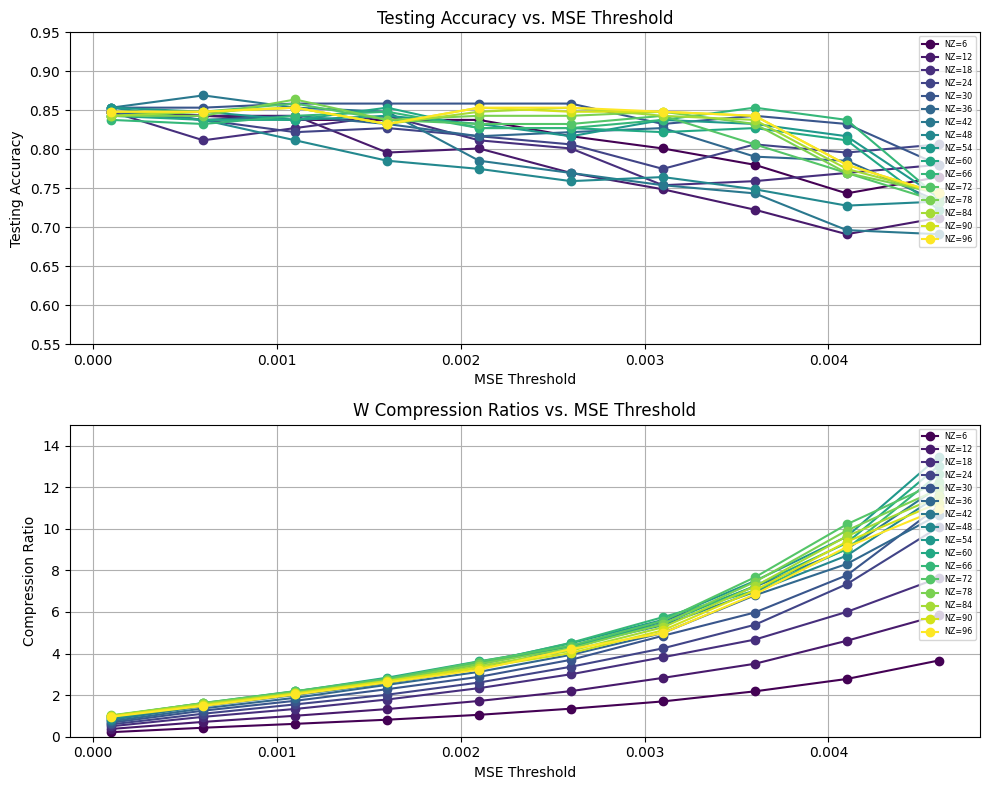

In [275]:
# %%capture
from matplotlib.cm import get_cmap

original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list4_2 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc = 8

NZ_list = list(range(3, 12 + 1, 1))

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for mse_threshold in mse_threshold_list2:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight4_2(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        y_test = np.argmax(labels_test, axis=-1)
        y_pred = np.argmax(lrcn(features_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(mse_threshold_list4_2, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(mse_threshold_list4_2, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. MSE Threshold')
axs[0].set_xlabel('MSE Threshold')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='upper right', fontsize='xx-small')
axs[0].set_ylim(0.55, 0.95)

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. MSE Threshold')
axs[1].set_xlabel('MSE Threshold')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')
axs[1].set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_81442/1015553506.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mse_color_map = get_cmap('plasma')


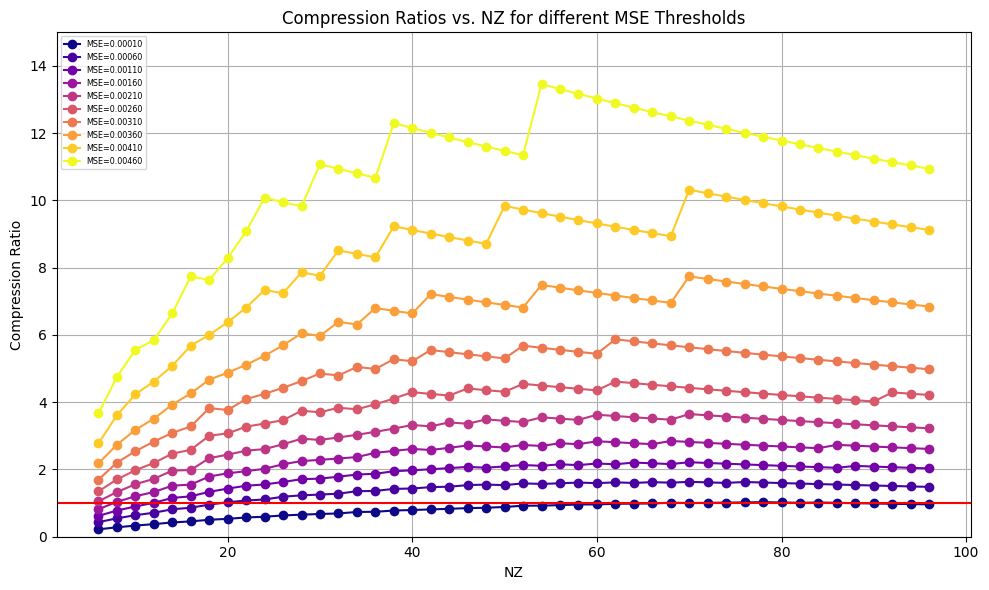

In [276]:
original_weights = lrcn.layers[-2].get_weights()

mse_threshold_list4_2 = np.linspace(0.0001, 0.0046, 10)

Nsteps = 1000
Tr = 1
Tc = 1

NZ_list = list(range(6, 96 + 1, 2))

# Define color map for MSE thresholds
mse_color_map = get_cmap('plasma')
mse_colors = mse_color_map(np.linspace(0, 1, len(mse_threshold_list2)))

# Separate Plot for Compression Ratios vs. NZ for different MSE Thresholds
fig, ax = plt.subplots(figsize=(10, 6))  # Dedicated figure and axes for this plot

for mse_index, mse_threshold in enumerate(mse_threshold_list2):
    # Reset metrics for each MSE threshold
    W_compression_ratios_mse = []

    for NZ in NZ_list:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, _ = approximate_weight4_2(Nsteps, NZ, Tr, Tc, mse_threshold, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Collect metrics for the current MSE threshold
        W_compression_ratios_mse.append(W_compression_ratio)

    # Plotting for the current MSE threshold with its corresponding color
    mse_color = mse_colors[mse_index]
    ax.plot(NZ_list, W_compression_ratios_mse, marker='o', linestyle='-', color=mse_color, label=f'MSE={mse_threshold:.5f}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Setting title, labels, and legend
ax.set_title('Compression Ratios vs. NZ for different MSE Thresholds')
ax.set_xlabel('NZ')
ax.set_ylabel('Compression Ratio')
ax.grid(True)
ax.legend(loc='upper left', fontsize='xx-small')
ax.axhline(y=1, color='red', linestyle='-')
ax.set_ylim(0, 15)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_99803/1181501374.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


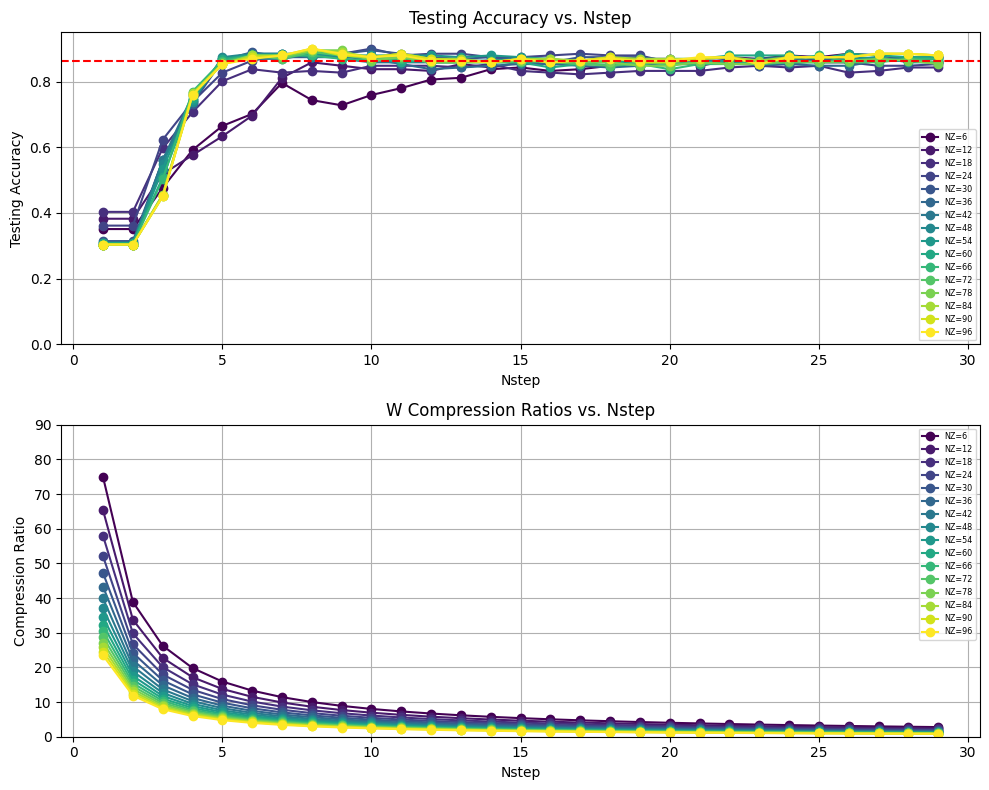

In [34]:
from matplotlib.cm import get_cmap

original_weights = lrcn.layers[-2].get_weights()

Tr = 1
Tc = 1

NZ_list = list(range(6, 96 + 1, 6))
Nstep_list = list(range(1,30,1))

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for Nstep in Nstep_list:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight2_step(Nstep, NZ, Tr, Tc, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        y_test = np.argmax(labels_test, axis=-1)
        y_pred = np.argmax(lrcn(features_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(Nstep_list, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(Nstep_list, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. Nstep')
axs[0].set_xlabel('Nstep')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='lower right', fontsize='xx-small')
axs[0].axhline(y=0.8638743455497382, color='red', linestyle='--')
axs[0].set_ylim(0, 0.95)

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. Nstep')
axs[1].set_xlabel('Nstep')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')
axs[1].set_ylim(0, 90)

plt.tight_layout()
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_99803/2024232076.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


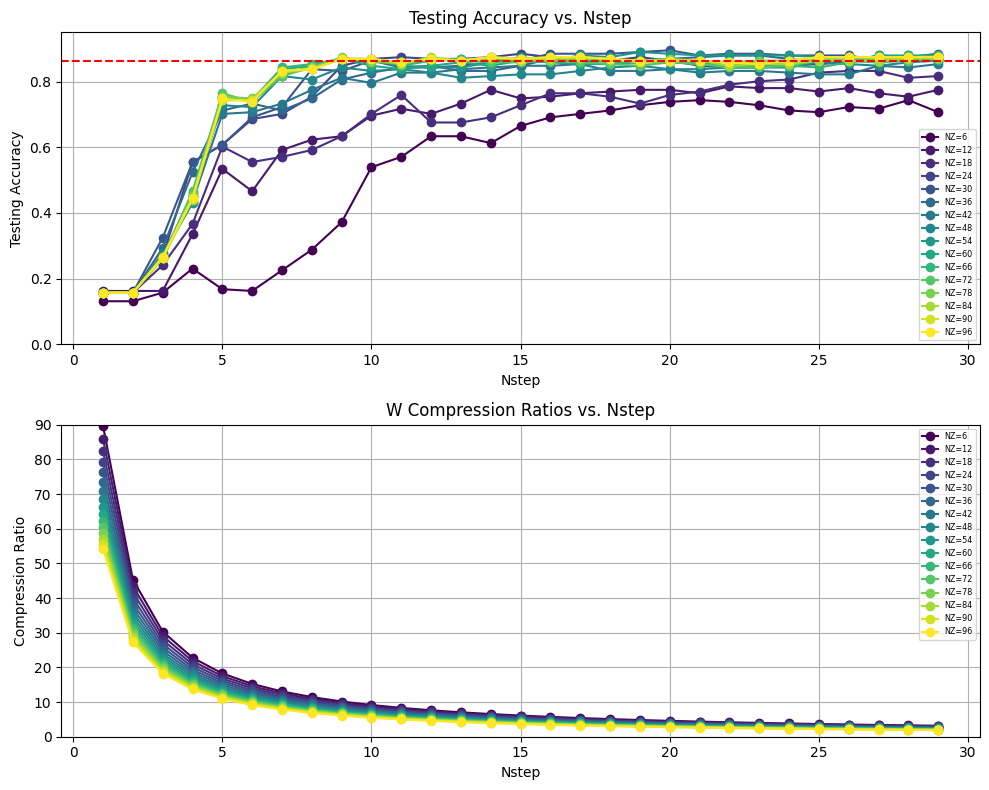

In [35]:
from matplotlib.cm import get_cmap

original_weights = lrcn.layers[-2].get_weights()

Tr = 1
Tc = 1

NZ_list = list(range(6, 96 + 1, 6))
Nstep_list = list(range(1,30,1))

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for nz_index, NZ in enumerate(NZ_list):
    # Reset metrics for each NZ value
    testing_accuracies_nz = []
    W_compression_ratios_nz = []

    for Nstep in Nstep_list:
        # Reset to original weights before each approximation
        lrcn.layers[-2].set_weights(original_weights)

        # Perform weight approximation
        approximated_kernel, approximated_recurrent_kernel, W_compression_ratio, H_compression_ratio = approximate_weight4_2_step(Nstep, NZ, Tr, Tc, lrcn.layers[-2])

        # Set the approximated weights
        approximated_weights = [approximated_kernel, approximated_recurrent_kernel, original_weights[2]]
        lrcn.layers[-2].set_weights(approximated_weights)

        # Make predictions and evaluate the model with approximated weights
        y_test = np.argmax(labels_test, axis=-1)
        y_pred = np.argmax(lrcn(features_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)

        # Collect metrics for the current NZ value
        testing_accuracies_nz.append(accuracy)
        W_compression_ratios_nz.append(W_compression_ratio)

    # Plotting for the current NZ value with its corresponding color
    color = colors[nz_index]
    axs[0].plot(Nstep_list, testing_accuracies_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')
    axs[1].plot(Nstep_list, W_compression_ratios_nz, marker='o', linestyle='-', color=color, label=f'NZ={NZ}')

# Restore original weights after all approximations
lrcn.layers[-2].set_weights(original_weights)

# Testing Accuracy vs. MSE Threshold Plot
axs[0].set_title('Testing Accuracy vs. Nstep')
axs[0].set_xlabel('Nstep')
axs[0].set_ylabel('Testing Accuracy')
axs[0].grid(True)
axs[0].legend(loc='lower right', fontsize='xx-small')
axs[0].axhline(y=0.8638743455497382, color='red', linestyle='--')
axs[0].set_ylim(0, 0.95)

# W Compression Ratios vs. MSE Threshold Plot
axs[1].set_title('W Compression Ratios vs. Nstep')
axs[1].set_xlabel('Nstep')
axs[1].set_ylabel('Compression Ratio')
axs[1].grid(True)
axs[1].legend(loc='upper right', fontsize='xx-small')
axs[1].set_ylim(0, 90)

plt.tight_layout()
plt.show()

In [22]:
import math
def performance_model_collective(Precision, R, C, NZ, Tr, Tc, Nsteps):
    # assume FPGA has a frequency of 100MHz
    frequency = 100 * 10 ** 6

    workload = (2*NZ + 2*R) * Nsteps + 37 * R
    front = max(math.ceil(R / Tr), math.ceil(NZ / Tc)) * Nsteps / 4
    back = 37 * math.ceil(R / Tr)
    II = max(front, back)
    Perf = workload / II * frequency / (10 ** 9)

    mem_access =  Precision * ((NZ + R) * Nsteps + 2 * R)
    CTC = workload/mem_access

    bandwidth = Perf / CTC

    return workload, II, Perf, mem_access, CTC, bandwidth


def performance_model_single(Precision, R, C, NZ, Tr, Tc, Nsteps):
    # assume FPGA has a frequency of 100MHz
    frequency = 100 * 10 ** 6

    workload = 4*(2*NZ + 2*R) * Nsteps + 37 * R
    front = max(math.ceil(R / Tr), math.ceil(NZ / Tc)) * Nsteps
    back = 37 * math.ceil(R / Tr)
    II = max(front, back)
    Perf = workload / II * frequency / (10 ** 9)

    mem_access =  Precision * (4 * (NZ + R) * Nsteps + 2 * R)
    CTC = workload/mem_access

    bandwidth = Perf / CTC

    return workload, II, Perf, mem_access, CTC, bandwidth

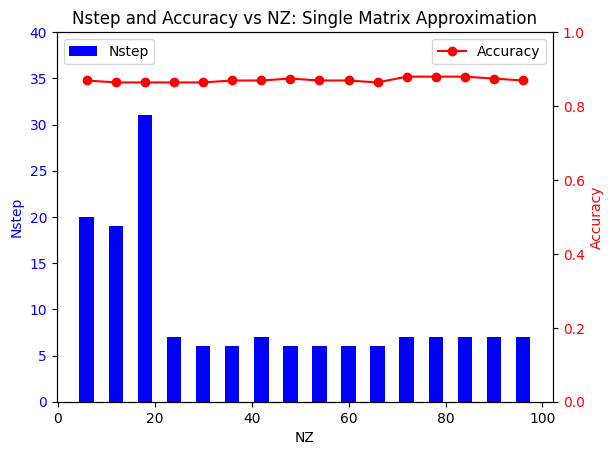

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('single.csv')

# Create a figure and a single subplot
fig, ax1 = plt.subplots()

# Plot Nstep vs NZ on the primary axis using a bar plot
ax1.bar(df['NZ'], df['Nstep'], color='blue', label='Nstep', width=3.0)
ax1.set_xlabel('NZ')
ax1.set_ylabel('Nstep', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0,40)

# Create a secondary axis sharing the same x-axis
ax2 = ax1.twinx()
# Plot Accuracy vs NZ on the secondary axis using a line plot
ax2.plot(df['NZ'], df['Accuracy'], color='red', label='Accuracy', marker='o', linestyle='-')
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Optional: add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylim(0,1)

# Optional: add a title
plt.title('Nstep and Accuracy vs NZ: Single Matrix Approximation')

# Show the plot
plt.show()


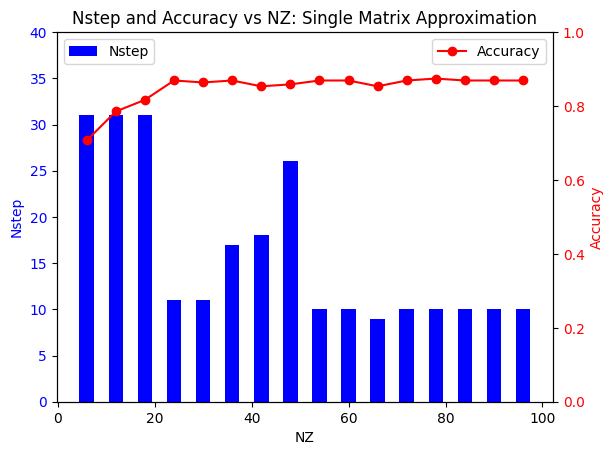

In [48]:
# Load the CSV file
df = pd.read_csv('collective.csv')

# Create a figure and a single subplot
fig, ax1 = plt.subplots()

# Plot Nstep vs NZ on the primary axis using a bar plot
ax1.bar(df['NZ'], df['Nstep'], color='blue', label='Nstep', width=3.0)
ax1.set_xlabel('NZ')
ax1.set_ylabel('Nstep', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0,40)

# Create a secondary axis sharing the same x-axis
ax2 = ax1.twinx()
# Plot Accuracy vs NZ on the secondary axis using a line plot
ax2.plot(df['NZ'], df['Accuracy'], color='red', label='Accuracy', marker='o', linestyle='-')
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Optional: add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylim(0,1)

# Optional: add a title
plt.title('Nstep and Accuracy vs NZ: Single Matrix Approximation')

# Show the plot
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_85269/2682176404.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


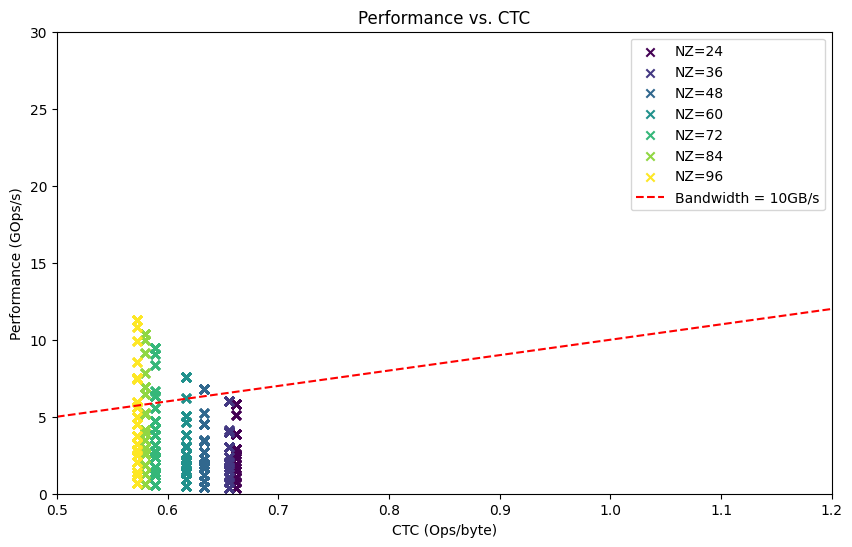

In [14]:
from matplotlib.cm import get_cmap

NZ_list = list(range(24, 96 + 1, 12))
Nstep_list = [7,6,6,6,7,7,7]
# precision in byte
Precision = 4
R = 32
C = 96

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

plt.figure(figsize=(10, 6))  # Set the figure size

for NZ_index, NZ in enumerate(NZ_list):
    Nsteps = Nstep_list[NZ_index]
    color = colors[NZ_index]  # Assign color based on NZ index
    first_point = True  # Indicator for the first point of each NZ to add the legend label
    for Tr in range(1,R+1,1):
        for Tc in range(1,NZ,1):
            # Assuming performance_model_single function is defined and returns the required values
            workload, II, Perf, mem_access, CTC, bandwidth = performance_model_single(Precision, R, C, NZ, Tr, Tc, Nsteps)

            if first_point:
                plt.scatter(CTC, Perf, color=color, marker='x', label=f"NZ={NZ}")
                first_point = False
            else:
                plt.scatter(CTC, Perf, color=color, marker='x')


ratio = 10  # Perf/CTC ratio

CTC1 = 0  # Example starting value
CTC2 = 1.5

# Calculate corresponding Perf values using the ratio
Perf1 = ratio * CTC1
Perf2 = ratio * CTC2

# Use plt.axline to draw the red line using two points (CTC1, Perf1) and (CTC2, Perf2)
plt.axline((CTC1, Perf1), (CTC2, Perf2), color='red', linestyle='--', label='Bandwidth = 10GB/s')

plt.title('Performance vs. CTC')
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('Performance (GOps/s)')
plt.xlim(0.5,1.2)
plt.legend()
plt.ylim(0,30)
plt.show()

/var/folders/6l/tkj8jq4d2c1fvr2j6g1kj0n40000gn/T/ipykernel_85269/2432374084.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis')


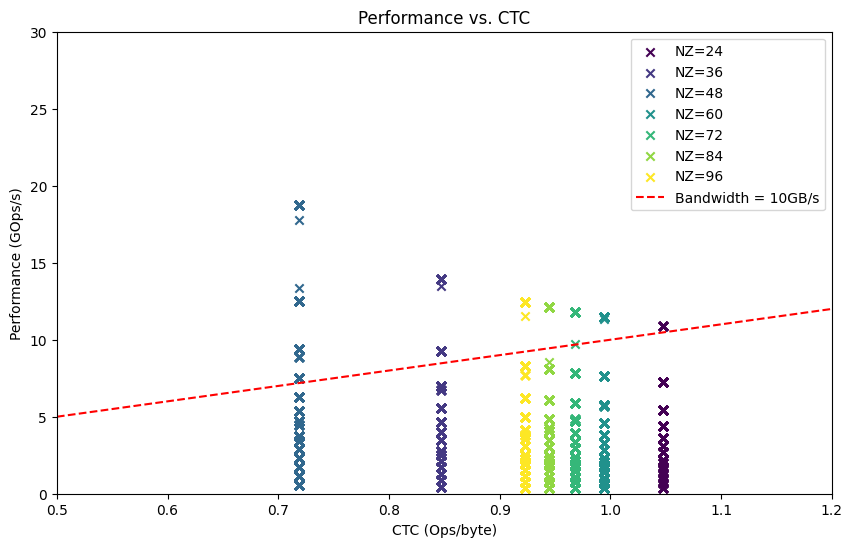

In [23]:
from matplotlib.cm import get_cmap

NZ_list = list(range(24, 96 + 1, 12))
Nstep_list = [11,17,26,10,10,10,10]
# precision in byte
Precision = 4
R = 128
C = 96

# Define color map
color_map = get_cmap('viridis')
colors = color_map(np.linspace(0, 1, len(NZ_list)))

plt.figure(figsize=(10, 6))  # Set the figure size

for NZ_index, NZ in enumerate(NZ_list):
    Nsteps = Nstep_list[NZ_index]
    color = colors[NZ_index]  # Assign color based on NZ index
    first_point = True  # Indicator for the first point of each NZ to add the legend label
    for Tr in range(1,32+1,1):
        for Tc in range(1,NZ,1):
            # Assuming performance_model_single function is defined and returns the required values
            workload, II, Perf, mem_access, CTC, bandwidth = performance_model_collective(Precision, R, C, NZ, Tr, Tc, Nsteps)

            if first_point:
                plt.scatter(CTC, Perf, color=color, marker='x', label=f"NZ={NZ}")
                first_point = False
            else:
                plt.scatter(CTC, Perf, color=color, marker='x')


ratio = 10  # Perf/CTC ratio

CTC1 = 0  # Example starting value
CTC2 = 1.5

# Calculate corresponding Perf values using the ratio
Perf1 = ratio * CTC1
Perf2 = ratio * CTC2

# Use plt.axline to draw the red line using two points (CTC1, Perf1) and (CTC2, Perf2)
plt.axline((CTC1, Perf1), (CTC2, Perf2), color='red', linestyle='--', label='Bandwidth = 10GB/s')

plt.title('Performance vs. CTC')
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('Performance (GOps/s)')
plt.xlim(0.5,1.2)
plt.legend()
plt.ylim(0,30)
plt.show()